In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gpflow
import trieste

from trieste.ask_tell_optimization import AskTellOptimizer
from trieste.bayesian_optimizer import Record
from trieste.data import Dataset
from trieste.models.gpflow.models import GaussianProcessRegression
from trieste.objectives.utils import mk_observer
from trieste.observer import OBJECTIVE
from trieste.space import Box
from util.plotting import plot_function_2d, plot_bo_points

np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
def build_model(data, kernel_func=None):
    """kernel_func should be a function that takes variance as a single input parameter"""
    variance = tf.math.reduce_variance(data.observations)
    if kernel_func is None:
        kernel = gpflow.kernels.Matern52(variance=variance)
    else:
        kernel = kernel_func(variance)
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)

    return GaussianProcessRegression(gpr)

def plot_ask_tell_results(ask_tell_result):
    dataset = ask_tell_result.try_get_final_dataset()
    query_points = dataset.query_points.numpy()
    observations = dataset.observations.numpy()
    fig, ax = plt.subplots()

    sc = ax.scatter(query_points[:, 0], query_points[:,1], c=observations)
    ax.set_ylabel('Pressure', loc='top')
    ax.set_xlabel('Speed', loc='left')
    cbar = fig.colorbar(sc)
    cbar.set_label("Material Accuracy", loc='top')

    plt.show()

In [3]:
search_space = Box([1, 1], [12, 7])
num_initial_points = 11
initial_data = trieste.data.Dataset(
    tf.constant([[1.3, 4.5], [12, 5], [1.6, 7], [5,5], [6,1], [1.2, 7], [1, 5.5], [12,5], [6,7], [1.2,3.5], [5,5]], dtype ='float64'), 
    tf.constant([[0.384], [0.462], [0.768], [0.332], [0.738], [1.404], [1.555], [0.462], [0.207], [0.149], [0.332]], dtype ='float64'))
#observer = trieste.observer.filter_finite(initial_data.query_points, initial_data.observations)

In [4]:
acq_rule = trieste.acquisition.rule.DiscreteThompsonSampling(
    num_search_space_samples=1000, num_query_points=5
)

Ask Trieste for configuration
New Configuration to Try # 1
Speed (mm/s):  10.75
Pressure (bars):  5.2 

New Configuration to Try # 2
Speed (mm/s):  10.48
Pressure (bars):  4.84 

New Configuration to Try # 3
Speed (mm/s):  9.27
Pressure (bars):  2.18 

New Configuration to Try # 4
Speed (mm/s):  4.29
Pressure (bars):  3.61 

New Configuration to Try # 5
Speed (mm/s):  10.29
Pressure (bars):  6.84 



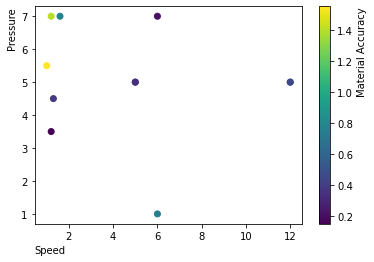

In [6]:
model = build_model(initial_data)
ask_tell = AskTellOptimizer(search_space, initial_data, model, acq_rule)

print("Ask Trieste for configuration")
new_config = ask_tell.ask()
for i in range(len(new_config)):
    print('New Configuration to Try #', i + 1)
    print('Speed (mm/s): ', np.round(new_config[i][0].numpy(),1))
    print('Pressure (bars): ', np.round(new_config[i][1].numpy(),1), '\n')

plot_ask_tell_results(ask_tell.to_result())